## **1. Importación de librerías**

In [1]:
# Tratamiento de datos.

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **2. Carga de datos `dataset_estudiantes.csv`**

Se importa el fichero `dataset_estudiantes.csv` en un DataFrame.

In [2]:
df = pd.read_csv("../data/1.raw/dataset_estudiantes.csv")

## **3. Preparación del entorno de entrenamiento para regresión**

In [3]:
y_regresion = df["nota_final"]

X = df.drop(columns=["nota_final", "aprobado"]) 

columns_num = ["horas_estudio_semanal", "nota_anterior", "tasa_asistencia", "horas_sueno", "edad"]

columns_cat = ["nivel_dificultad", "tiene_tutor", "horario_estudio_preferido", "estilo_aprendizaje"]

transform_num = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

transform_cat = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Desconocido")),("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(transformers=[("num", transform_num, columns_num), ("cat", transform_cat, columns_cat)])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regresion, test_size=0.2, random_state=42)

En este bloque se vuelven a definir las variables necesarias para el entrenamiento del modelo de regresión, ya que al trabajar en una hoja nueva no se mantienen las variables creadas en la fase anterior, de esta manera se deja listo el entorno para entrenar y validar los modelos en esta fase.

## **4. Función de evaluación de regresión**

In [4]:
def eval_regression(y_true, y_pred):
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return mae, rmse, r2

En este paso se define la función `eval_regression`, cuyo objetivo es calcular de forma automática y consistente las principales métricas de evaluación para regresión.

La función devuelve tres métricas: 

- **MAE**: mide el error medio absoluto en las mismas unidades que la nota. 
- **RMSE**: penaliza más los errores grandes al usar la raíz del error cuadrático medio. 
- **R²**: que indica qué proporción de la variabilidad de `nota_final` es explicada por el modelo. 

De esta forma, se evita repetir código y se facilita la comparación entre distintos modelos usando siempre los mismos criterios.

## **5. Baseline: DummyRegressor**

In [5]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_reg, y_train_reg)

pred_test = dummy.predict(X_test_reg)
mae, rmse, r2 = eval_regression(y_test_reg, pred_test)

print("Dummy (baseline) - Test")
print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")

Dummy (baseline) - Test
MAE: 7.248 | RMSE: 9.057 | R2: -0.003


**Observaciones:**

Este modelo baseline sirve como referencia mínima, ya que predice siempre la media de `nota_final` del conjunto de entrenamiento. En test obtiene un **MAE** de **7.248** y un **RMSE** de **9.057**, lo que indica un error medio de alrededor de 7 puntos en la nota final, con penalización mayor en los errores grandes. El **R²** es **-0.003**, lo que significa que el modelo no mejora respecto a predecir la media, de hecho, rinde ligeramente peor que un modelo constante, confirmando que se trata de un punto de partida básico que los modelos reales deberían superar.

## **6. Modelo 1: Regresión lineal con Pipeline**

In [6]:
lin_reg = Pipeline(steps=[("preprocess", preprocess),("model", LinearRegression())])

lin_reg.fit(X_train_reg, y_train_reg)

pred_train = lin_reg.predict(X_train_reg)
pred_test  = lin_reg.predict(X_test_reg)

mae_tr, rmse_tr, r2_tr = eval_regression(y_train_reg, pred_train)
mae_te, rmse_te, r2_te = eval_regression(y_test_reg, pred_test)

print("LinearRegression")
print(f"Train -> MAE: {mae_tr:.3f} | RMSE: {rmse_tr:.3f} | R2: {r2_tr:.3f}")
print(f"Test  -> MAE: {mae_te:.3f} | RMSE: {rmse_te:.3f} | R2: {r2_te:.3f}")

LinearRegression
Train -> MAE: 6.029 | RMSE: 7.550 | R2: 0.392
Test  -> MAE: 5.816 | RMSE: 7.246 | R2: 0.358


**Observaciones:**

El modelo de **Regresión Lineal** se entrena dentro de un **Pipeline** junto con el preprocesamiento, lo que garantiza que la imputación, el escalado y el **One-Hot Encoding** se aplican correctamente antes de ajustar el modelo. 

En entrenamiento obtiene **MAE** de **6.029**, **RMSE** de **7.550** y **R²** de **0.392**, mientras que en test logra **MAE** de **5.816**, **RMSE** de **7.246** y **R²** de **0.358**. Estos resultados muestran una mejora clara frente al baseline, ya que el modelo explica alrededor del **36%** de la variabilidad en test y reduce el error medio respecto al **DummyRegressor**. Además, la diferencia entre train y test es pequeña, lo que sugiere una generalización sin señales evidentes de sobreajuste.

## **7. Validación cruzada del modelo lineal**

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"MAE": "neg_mean_absolute_error","RMSE": "neg_root_mean_squared_error","R2": "r2"}

cv_results = cross_validate(lin_reg, X_train_reg, y_train_reg, cv=cv, scoring=scoring)

print("CV LinearRegression (media)")
print(f"MAE:  {-cv_results['test_MAE'].mean():.3f}")
print(f"RMSE: {-cv_results['test_RMSE'].mean():.3f}")
print(f"R2:   {cv_results['test_R2'].mean():.3f}")

CV LinearRegression (media)
MAE:  6.198
RMSE: 7.741
R2:   0.358


**Observaciones:**

La validación cruzada con 5 particiones permite evaluar el modelo de forma más robusta que un único split, ya que estima su rendimiento medio en distintos subconjuntos del entrenamiento. Los resultados medios obtenidos para la regresión lineal son **MAE** de **6.198**, **RMSE** de **7.741** y **R²** de **0.358**, lo que confirma un rendimiento estable y coherente con el observado en el conjunto de prueba. En conjunto, el modelo mantiene una capacidad explicativa moderada y errores controlados, sin depender excesivamente de una única partición de los datos.

## **8. Modelo 2: Ridge + búsqueda de alpha**

In [8]:
ridge = Pipeline(steps=[("preprocess", preprocess),("model", Ridge())])

param_grid = {"model__alpha": np.logspace(-3, 3, 13)}

grid_ridge = GridSearchCV(ridge, param_grid=param_grid, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)

grid_ridge.fit(X_train_reg, y_train_reg)

print("Mejor alpha (Ridge):", grid_ridge.best_params_["model__alpha"])
print("Mejor RMSE CV:", -grid_ridge.best_score_)

Mejor alpha (Ridge): 100.0
Mejor RMSE CV: 7.696162830693458


**Observaciones:**

Se entrenó un modelo **Ridge Regression** integrado en un **Pipeline** junto con el preprocesamiento y se optimizó el hiperparámetro principal **alpha** mediante **GridSearchCV** con validación cruzada de 5 particiones, utilizando el **RMSE** como métrica principal. El mejor valor encontrado fue **alpha = 100.0**, lo que indica que una regularización moderada mejora la capacidad de generalización del modelo. Con esta configuración, el rendimiento medio en validación cruzada alcanza un **RMSE** de **7.696**, que se toma como referencia para comparar y seleccionar el modelo final antes de evaluarlo sobre el conjunto de prueba.

## **9. Evaluación final del mejor Ridge en test**

In [9]:
best_ridge = grid_ridge.best_estimator_

pred_test = best_ridge.predict(X_test_reg)
mae, rmse, r2 = eval_regression(y_test_reg, pred_test)

print("Ridge (best) - Test")
print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")

Ridge (best) - Test
MAE: 5.846 | RMSE: 7.206 | R2: 0.365


**Observaciones:**

El modelo **Ridge** optimizado con **GridSearchCV** se evalúa finalmente sobre el conjunto de prueba utilizando el mejor valor de **alpha** encontrado en validación cruzada. En test obtiene **MAE** de **5.846**, **RMSE** de **7.206** y **R²** de **0.365**, lo que supone un rendimiento muy similar al de la regresión lineal y una ligera mejora en **RMSE** y en capacidad explicativa. Esto indica que la regularización ayuda a ajustar el modelo de forma algo más estable y a generalizar ligeramente mejor, por lo que **Ridge** puede considerarse una opción adecuada como modelo final de regresión para este problema.

## **10. Tabla resumen de modelos**

In [10]:
resultados = []

pred_dummy = dummy.predict(X_test_reg) 
mae_d, rmse_d, r2_d = eval_regression(y_test_reg, pred_dummy)

resultados.append({
    "Modelo": "DummyRegressor (baseline)",
    "MAE_test": mae_d,
    "RMSE_test": rmse_d,
    "R2_test": r2_d
})

pred_lin = lin_reg.predict(X_test_reg)  
mae_l, rmse_l, r2_l = eval_regression(y_test_reg, pred_lin)

resultados.append({
    "Modelo": "LinearRegression",
    "MAE_test": mae_l,
    "RMSE_test": rmse_l,
    "R2_test": r2_l,
    "MAE_CV": -cv_results["test_MAE"].mean(),
    "RMSE_CV": -cv_results["test_RMSE"].mean(),
    "R2_CV": cv_results["test_R2"].mean()
})

best_ridge = grid_ridge.best_estimator_  
pred_ridge = best_ridge.predict(X_test_reg)
mae_r, rmse_r, r2_r = eval_regression(y_test_reg, pred_ridge)

alpha_best = best_ridge.named_steps["model"].alpha

resultados.append({
    "Modelo": f"Ridge (best alpha={alpha_best})",
    "MAE_test": mae_r,
    "RMSE_test": rmse_r,
    "R2_test": r2_r,
    "RMSE_CV": -grid_ridge.best_score_
})

resumen_modelos = pd.DataFrame(resultados).set_index("Modelo").round(3)
resumen_modelos

,MAE_test,RMSE_test,R2_test,MAE_CV,RMSE_CV,R2_CV
Modelo,,,,,,
DummyRegressor (baseline),7.248,9.057,-0.003,NaN,NaN,NaN
LinearRegression,5.816,7.246,0.358,6.198,7.741,0.358
Ridge (best alpha=100.0),5.846,7.206,0.365,NaN,7.696,NaN


**Observaciones:**

La tabla resumen permite comparar de forma directa el rendimiento de los tres enfoques. El **baseline** confirma un punto de partida exigente, ya que sus errores son claramente superiores y no aporta capacidad explicativa. Tanto la **regresión lineal** como **Ridge** reducen el error de manera notable y muestran resultados consistentes entre test y validación cruzada. Entre ambos, **Ridge** ofrece una mejora ligera en **RMSE** y **R²** en test, lo que sugiere un ajuste algo más estable gracias a la regularización, por lo que resulta una opción razonable como modelo final.


## **11. Visualizaciones del modelo final**

#### **Real vs Predicho**

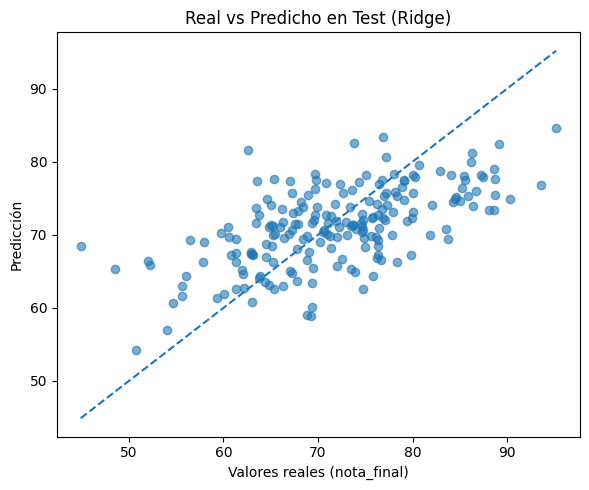

In [11]:
y_pred_test = best_ridge.predict(X_test_reg)

plt.figure(figsize=(6,5))
plt.scatter(y_test_reg, y_pred_test, alpha=0.6)

min_val = min(y_test_reg.min(), y_pred_test.min())
max_val = max(y_test_reg.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.xlabel("Valores reales (nota_final)")
plt.ylabel("Predicción")
plt.title("Real vs Predicho en Test (Ridge)")
plt.tight_layout()
plt.show()

**Observaciones:**

Las predicciones siguen una tendencia positiva, muchos puntos quedan relativamente cerca de la línea diagonal, lo que indica que el modelo capta parte de la relación entre las variables y `nota_final`. Aun así, se aprecia un efecto de regresión a la media, para valores reales bajos tiende a sobreestimar y para valores reales altos tiende a infraestimar, reduciendo la precisión en los extremos.

#### **Residuos vs Predicción**

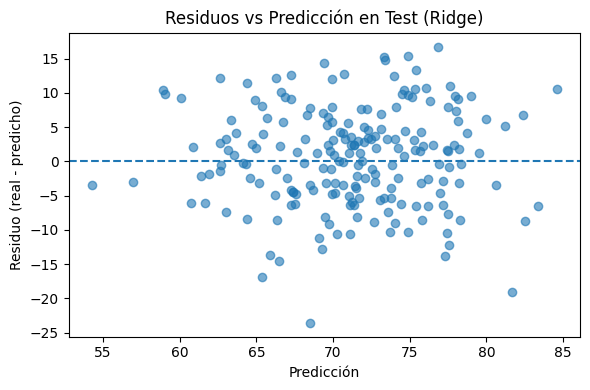

In [12]:
y_pred_test = best_ridge.predict(X_test_reg)
residuos_test = y_test_reg - y_pred_test

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuos_test, alpha=0.6)
plt.axhline(0, linestyle="--")

plt.xlabel("Predicción")
plt.ylabel("Residuo (real - predicho)")
plt.title("Residuos vs Predicción en Test (Ridge)")
plt.tight_layout()
plt.show()

**Observaciones:**

Los residuos se distribuyen alrededor de 0 sin un patrón claro, lo que sugiere que no hay un sesgo sistemático fuerte en función del valor predicho. Sin embargo, aparecen algunos valores atípicos con errores grandes tanto positivos como negativos, y la dispersión no es completamente uniforme, indicando que el modelo comete errores en ciertos casos concretos.

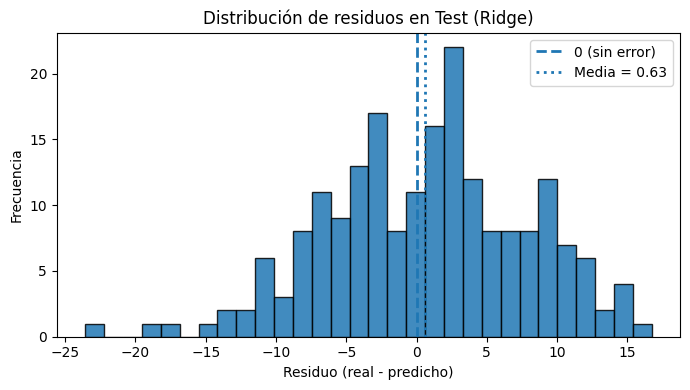

In [13]:
residuos_test = y_test_reg - best_ridge.predict(X_test_reg)

plt.figure(figsize=(7,4))
plt.hist(residuos_test, bins=30, edgecolor="black", alpha=0.85)

plt.axvline(0, linestyle="--", linewidth=2, label="0 (sin error)")
plt.axvline(residuos_test.mean(), linestyle=":", linewidth=2, label=f"Media = {residuos_test.mean():.2f}")

plt.title("Distribución de residuos en Test (Ridge)")
plt.xlabel("Residuo (real - predicho)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

**Observaciones:**

La distribución de residuos en test se concentra principalmente alrededor de **0**, lo que indica que el modelo no presenta un sesgo fuerte y que, en promedio, las predicciones están razonablemente centradas. La mayor parte de los errores se concentran en un rango moderado, aunque se observan algunos casos aislados con residuos muy negativos y positivos, señal de predicciones con errores grandes en ciertas observaciones. En conjunto, el histograma sugiere un comportamiento general estable, pero con presencia de outliers que pueden explicar parte del **RMSE** obtenido.

## **12. Interpretación de Coeficientes**

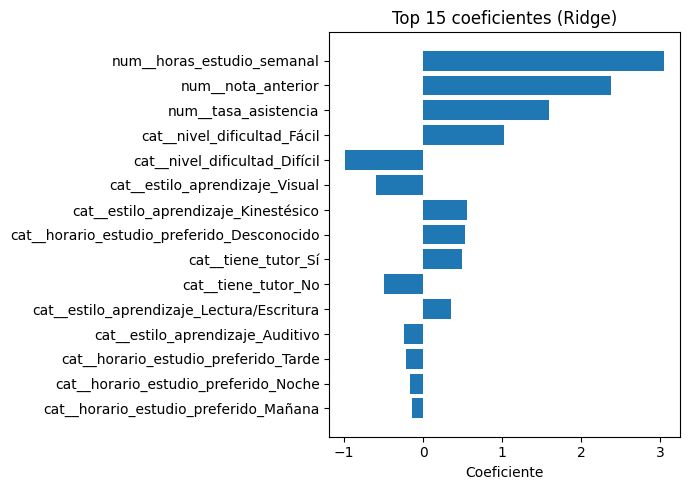

In [14]:

feature_names = best_ridge.named_steps["preprocess"].get_feature_names_out()
coefs = best_ridge.named_steps["model"].coef_

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
top = coef_df.sort_values("abs_coef", ascending=False).head(15)

plt.figure(figsize=(7,5))
plt.barh(top["feature"][::-1], top["coef"][::-1])
plt.xlabel("Coeficiente")
plt.title("Top 15 coeficientes (Ridge)")
plt.tight_layout()
plt.show()

**Observaciones:**

En el gráfico muestra los 15 coeficientes más relevantes del modelo Ridge, se observa que las variables numéricas aportan la mayor parte de la señal. `horas_estudio_semanal`, `nota_anterior` y `tasa_asistencia` presentan los coeficientes positivos de mayor magnitud, indicando que, manteniendo el resto constante, un aumento en estas variables se asocia con una mayor `nota_final`. Entre las variables categóricas, `nivel_dificultad_Fácil` aparece con efecto positivo y `nivel_dificultad_Difícil` con efecto negativo, lo que sugiere diferencias sistemáticas en la nota según el nivel declarado. También se aprecian contribuciones moderadas de categorías como `estilo_aprendizaje` y `tiene_tutor`, aunque con magnitudes inferiores a las numéricas. <br> 
En conjunto, el modelo apoya lo observado en el EDA, el tiempo de estudio, el rendimiento previo y la asistencia son los factores más influyentes, mientras que las variables categóricas actúan como ajustes secundarios.

## **13. Guardado del modelo final**

In [15]:
os.makedirs("../models", exist_ok=True)

joblib.dump(best_ridge, "../models/modelo_regresion_ridge.pkl")

['../models/modelo_regresion_ridge.pkl']

Se procede a guardar el modelo final de regresión, incluyendo todo el Pipeline de preprocesamiento y el estimador entrenado, en el archivo `modelo_regresion_ridge.pkl` disponible en la carpeta `models/` mediante `joblib.dump`.

In [16]:
os.path.exists("../models/modelo_regresion_ridge.pkl")

True

Se verifica que el archivo del modelo se ha guardado correctamente comprobando la existencia de la ruta en el sistema, lo que confirma que el fichero `modelo_regresion_ridge.pkl` está disponible en la carpeta models.

## **14. Conclusiones**

El modelo **baseline** con **DummyRegressor**, que predice siempre la media de `nota_final`, sirve como referencia mínima y obtiene en test un **MAE** de **7.248**, un **RMSE** de **9.057** y un **R²** de **-0.003**, lo que confirma que predecir la media no captura relaciones útiles, indicando que no es capaz de explicar la variabilidad de las notas. En cambio, la **Regresión Lineal** integrada en un **Pipeline** con preprocesamiento mejora de forma notable, con un **MAE** de **5.816**, **RMSE** de **7.246** y **R²** de **0.358** en test, además de un rendimiento medio en validación cruzada muy similar, lo que sugiere una generalización razonable. <br> 
Posteriormente, se entrena un modelo **Ridge** y se optimiza el hiperparámetro **alpha** mediante **GridSearchCV**, obteniendo como mejor configuración **alpha = 100** y un **RMSE** medio en CV de **7.696**, lo que refleja una ligera mejora frente al modelo lineal. Al evaluar este **Ridge** optimizado en test, se obtiene **MAE** de **5.846**, **RMSE** de **7.206** y **R²** de **0.365**, con una mejora pequeña pero consistente en **RMSE** y **R²**. Por esta razón, se selecciona **Ridge** como modelo final de regresión, ya que mantiene un rendimiento ligeramente superior y aporta regularización, lo que favorece una mejor estabilidad y capacidad de generalización.